In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Use `engine.execute` to select and display the first 10 rows from the table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Grabs the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [13]:
# to get the last 12 months of data, last date - 365
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print(last_year)

2016-08-22


In [14]:
# query to pull the last year of precipitation data
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

In [15]:
# Load the data from the query into a dataframe

rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [16]:
# reset the index to the date

rain_df.set_index('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


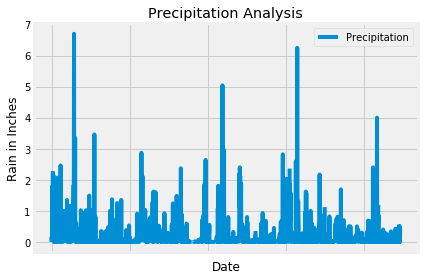

In [18]:
# plot the dataframe
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain ")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?

locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [21]:
# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print(station,count)

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [23]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()



In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

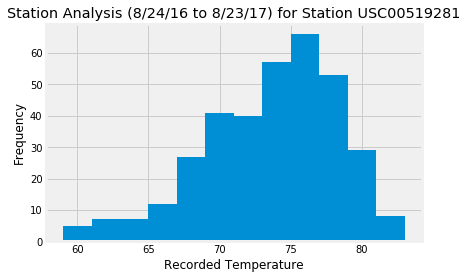

In [26]:
# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps (start_date, end_date):
    temp_queries = session.query(func.min(Measurement.tobs),\
                             func.round(func.avg(Measurement.tobs)),\
                             func.max(Measurement.tobs)).\
    filter(Measurement.date.between(start_date, end_date)).all()
    
    min_temp = temp_queries[0][0]
    avg_temp = temp_queries[0][1]
    max_temp = temp_queries[0][2]
    
    
    print(f"Minimum Temperature: {min_temp}.")
    print(f"Average Temperature: {avg_temp}.")
    print(f"Maximum Temperature: {max_temp}.")
    
    return {"Minimum": min_temp, "Average": avg_temp, "Maximum": max_temp}

prev_start_date = "2012-02-28"
prev_end_date = "2012-03-05"
prev_yr_temps = calc_temps(prev_start_date, prev_end_date)
prev_yr_temps

Minimum Temperature: 62.0.
Average Temperature: 70.0.
Maximum Temperature: 74.0.


{'Minimum': 62.0, 'Average': 70.0, 'Maximum': 74.0}

In [33]:
# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2012, 2, 28)
trip_leave = dt.date(2012, 3, 5)
last_year = dt.timedelta(days=366)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(61.0, 69.94545454545455, 75.0)]


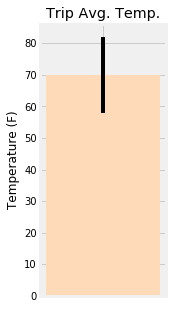

In [37]:
# plotting the data as a boxplot

plt.figure(figsize = (2, 5))
plt.title("Trip Avg. Temp.")
plt.ylabel("Temperature (F)")
plt.bar(1, prev_yr_temps["Average"], yerr = int(prev_yr_temps["Maximum"] - prev_yr_temps["Minimum"]), tick_label = "", color = "#FFDAB9")
plt.show()